In [1]:
pip install torchaudio

     |████████████████████████████████| 2.9 MB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 881.9 MB 267 bytes/s a 0:00:0104
ERROR: torchvision 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.10.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
Note: you may need to restart the kernel to use updated packages.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Importing all neccessary libraries

In [3]:
import warnings
warnings. filterwarnings("ignore")
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms as tfs
import numpy as np
import pandas as pd 
from torch.nn import Sequential as sq
from torch.nn import Linear as lnr
from torch import argmax as agm
from torch.nn import Module as ml


## Evaluation Metrics implementation (WER and CER)

In [4]:

def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):

    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
  
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
 
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

class TextTransform:
    def __init__(self):
        self.char_map={"'": 0, '': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
        self.index_map={0: "'", 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}
        
    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    
    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

## The NVIDIA System Management Interface (management and monitoring of NVIDIA GPU devices)

In [5]:
!nvidia-smi

Tue Nov  9 22:30:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla K80    On   | 00000001:00:00.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **CNN layer**

In [6]:
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        x = x.transpose(2, 3).contiguous() 
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() 


class ResidualCNN(nn.Module):

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x 
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x 




# **Gated Recurrent Unit layer**

In [7]:
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


# Final Automatic Speech Recognition Model architecture

In [8]:


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2) 
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3]) 
        x = x.transpose(1, 2) 
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

# Training and Testing Code

In [9]:
class IterMeter(object):
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms) 
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

    
        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []

    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
  
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    # filename='./best_fit_model'+str(epoch)+'.h5'
    # torch.save(model,filename)




# Hyperparameters of the model

In [10]:
learning_rate = 5e-4
batch_size = 5
epochs = 10
train_url = "train-clean-100"
test_url = "test-clean"

In [14]:
if not os.path.isdir("./data"):
    os.makedirs("./data")
#train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

In [15]:
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 5,
    "rnn_dim": 512,
    "n_class": 29,
    "n_feats": 128,
    "stride":2,
    "dropout": 0.1,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs
}

use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)
test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=int(len(train_loader)),epochs=hparams['epochs'],anneal_strategy='linear')

iter_meter = IterMeter()


SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

# Code for model training and testing (Optional)


> This code snippet should only be used for base model training.

> Since we already have our based model trained , we will skip this part and load our trained model directly






In [ ]:
# for epoch in range(1, epochs+1):
#     train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
#     test(model, device, test_loader, criterion, epoch, iter_meter)

# Loading the best fit model


*   The base model for slurred speech Recognition has been trained on kaggle for 10 epoch.
*   It has been trained on Librispeech Corpus Speech Dataset



In [27]:
# import os 
# print(os.getcwd())

loaded_model = torch.load('/mnt/batch/tasks/shared/LS_root/mounts/clusters/shivam1234/code/Users/kshivamranjan.cse18/Best-Fit-TrainedModel/best_fit_model_final.h5')


/mnt/batch/tasks/shared/LS_root/mounts/clusters/shivam1234/code/Users/kshivamranjan.cse18


In [28]:
print(loaded_model)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

# Testing our loaded base model

In [29]:
test(loaded_model, device, test_loader, criterion, 1, iter_meter)


evaluating...
Test set: Average loss: 0.4613, Average CER: 0.100144 Average WER: 0.1190



In [30]:
import os
from typing import Tuple, Union
from pathlib import Path
import torchaudio
from torch import Tensor
from torch.utils.data import Dataset


def load_librispeech_item(fileid,path,ext_audio,ext_txt):
    speaker_id, chapter_id, utterance_id = fileid.split("-")

    file_text = speaker_id + "-" + chapter_id + ext_txt
    file_text = os.path.join(path, speaker_id, chapter_id, file_text)

    fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    file_audio = fileid_audio + ext_audio
    file_audio = os.path.join(path, speaker_id, chapter_id, file_audio)

    waveform, sample_rate = torchaudio.load(file_audio)

    with open(file_text) as ft:
        for line in ft:
            fileid_text, utterance = line.strip().split(" ", 1)
            if fileid_audio == fileid_text:
                break
        else:
            raise FileNotFoundError("Translation not found for " + fileid_audio)

    return (waveform,sample_rate,utterance,int(speaker_id),int(chapter_id),int(utterance_id),)


## Custom class for loading Slurred Speech Test Dataset in Pytorch

In [31]:
class TestDataset(Dataset): 
    _ext_txt = ".trans.txt"
    _ext_audio = ".flac"
    def __init__(self):
        self._path="/mnt/batch/tasks/shared/LS_root/mounts/clusters/shivam1234/code/Users/kshivamranjan.cse18/SlurredSpeech_Dataset_Test"
        self._walker=['1-2-0000', '1-2-0001', '1-2-0002', '1-2-0003', '1-2-0004', '1-2-0005', '1-2-0006', '1-2-0007', '1-2-0008', '1-2-0009', '1-2-0010', '1-2-0011', '1-2-0012', '1-2-0013', '1-2-0014', '1-2-0015', '1-2-0016', '1-2-0017', '1-2-0018', '1-2-0019', '1-2-0020', '1-2-0021', '1-2-0022', '1-2-0023', '1-2-0024', '1-2-0025', '1-2-0026', '1-2-0027', '1-2-0028', '1-2-0029', '1-2-0030', '1-2-0031', '1-2-0032', '1-2-0033', '1-2-0034', '1-2-0035', '1-2-0036', '1-2-0037', '1-2-0038', '1-2-0039', '1-2-0040', '1-2-0041', '1-2-0042', '1-2-0043', '1-2-0044', '1-2-0045', '1-2-0046', '1-2-0047', '1-2-0048', '1-2-0049', '1-2-0050', '1-2-0051', '1-2-0052', '1-2-0053', '1-2-0054', '1-2-0055', '1-2-0056', '1-2-0057', '1-2-0058', '1-2-0059', '1-2-0060', '1-2-0061', '1-2-0062', '1-2-0063', '1-2-0064', '1-2-0065', '1-2-0066', '1-2-0067', '1-2-0068', '1-2-0069', '1-2-0070', '1-2-0071', '1-2-0072', '1-2-0073', '1-2-0074', '1-2-0075', '1-2-0076', '1-2-0077', '1-2-0078', '1-2-0079', '1-2-0080', '1-2-0081', '1-2-0082', '1-2-0083', '1-2-0084', '1-2-0085', '1-2-0086', '1-2-0087', '1-2-0088', '1-2-0089', '1-2-0090', '1-2-0091', '1-2-0092', '1-2-0093', '1-2-0094', '1-2-0095', '1-2-0096', '1-2-0097', '1-2-0098', '1-2-0099']

    def __getitem__(self, n):
        fileid = self._walker[n]
        return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)

    def __len__(self):
        return len(self._walker)   
    
    
testDataset_slurred_speech=TestDataset()

## Custom class for loading Slurred Speech Train Dataset in Pytorch

In [32]:
class TrainDataset(Dataset): 
    _ext_txt = ".trans.txt"
    _ext_audio = ".flac"
    def __init__(self):
        self._path="/mnt/batch/tasks/shared/LS_root/mounts/clusters/shivam1234/code/Users/kshivamranjan.cse18/SlurredSpeech_Dataset_Train"
        self._walker=['1-2-0000', '1-2-0001', '1-2-0002', '1-2-0003', '1-2-0004', '1-2-0005', '1-2-0006', '1-2-0007', '1-2-0008', '1-2-0009', '1-2-0010', '1-2-0011', '1-2-0012', '1-2-0013', '1-2-0014', '1-2-0015', '1-2-0016', '1-2-0017', '1-2-0018', '1-2-0019', '1-2-0020', '1-2-0021', '1-2-0022', '1-2-0023', '1-2-0024', '1-2-0025', '1-2-0026', '1-2-0027', '1-2-0028', '1-2-0029', '1-2-0030', '1-2-0031', '1-2-0032', '1-2-0033', '1-2-0034', '1-2-0035', '1-2-0036', '1-2-0037', '1-2-0038', '1-2-0039', '1-2-0040', '1-2-0041', '1-2-0042', '1-2-0043', '1-2-0044', '1-2-0045', '1-2-0046', '1-2-0047', '1-2-0048', '1-2-0049', '1-2-0050', '1-2-0051', '1-2-0052', '1-2-0053', '1-2-0054', '1-2-0055', '1-2-0056', '1-2-0057', '1-2-0058', '1-2-0059', '1-2-0060', '1-2-0061', '1-2-0062', '1-2-0063', '1-2-0064', '1-2-0065', '1-2-0066', '1-2-0067', '1-2-0068', '1-2-0069', '1-2-0070', '1-2-0071', '1-2-0072', '1-2-0073', '1-2-0074', '1-2-0075', '1-2-0076', '1-2-0077', '1-2-0078', '1-2-0079', '1-2-0080', '1-2-0081', '1-2-0082', '1-2-0083', '1-2-0084', '1-2-0085', '1-2-0086', '1-2-0087', '1-2-0088', '1-2-0089', '1-2-0090', '1-2-0091', '1-2-0092', '1-2-0093', '1-2-0094', '1-2-0095', '1-2-0096', '1-2-0097', '1-2-0098', '1-2-0099']

    def __getitem__(self, n):
        fileid = self._walker[n]
        return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)

    def __len__(self):
        return len(self._walker)   
    
    
trainDataset_slurred_speech=TrainDataset()

In [33]:

testDataLoaderSlurred = data.DataLoader(dataset=testDataset_slurred_speech,batch_size=hparams['batch_size'],shuffle=False,collate_fn=lambda x: data_processing(x, 'valid'),**kwargs)
trainDataLoderSlurred = data.DataLoader(dataset=trainDataset_slurred_speech,batch_size=hparams['batch_size'],shuffle=False,collate_fn=lambda x: data_processing(x, 'valid'),**kwargs)



# Testing our base model before fine tuning on slurred speech dataset

In [34]:
test(loaded_model, device, testDataLoaderSlurred, criterion, 1, iter_meter)


evaluating...
Test set: Average loss: 4.3406, Average CER: 0.673538 Average WER: 0.6378



# Transfer learning Training and Testing

In [35]:
class IterMeter(object):
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

def train_transfer_learning(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms) 
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

    
        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test_transfer_learning(model, device, test_loader, criterion, epoch, iter_meter,losses,character_error_rates,word_error_rates):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    losses.append(test_loss)
    character_error_rates.append(avg_cer)
    word_error_rates.append(avg_wer)
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    # filename='./best_fit_model'+str(epoch)+'.h5'
    # torch.save(model,filename)




# Applying transfer learning

In [36]:
def transfer_learning_type1(pre_trained_model):
  hparams = {"learning_rate": 5e-4,"batch_size": 5,"epochs": 20}
  opti = optim.AdamW(pre_trained_model.parameters(), hparams['learning_rate'])
  crit = nn.CTCLoss(blank=28).to(device)
  sche = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=int(len(trainDataLoderSlurred)),epochs=hparams['epochs'],anneal_strategy='linear')
  iter = IterMeter()
  losses=[]
  character_error_rates=[]
  word_error_rates=[]
  for epoch in range(1, hparams['epochs']+1):
    train_transfer_learning(pre_trained_model, device, trainDataLoderSlurred, crit, opti, sche, epoch, iter)
    test_transfer_learning(pre_trained_model, device, testDataLoaderSlurred, crit, epoch, iter,losses,character_error_rates,word_error_rates)

transfer_learning_type1(loaded_model)


Train Epoch: 1 [0/100 (0%)]	Loss: 4.572165

evaluating...
Test set: Average loss: 2.8773, Average CER: 0.996303 Average WER: 0.9633

Train Epoch: 2 [0/100 (0%)]	Loss: 2.746296

evaluating...
Test set: Average loss: 3.0265, Average CER: 1.000000 Average WER: 0.9665

Train Epoch: 3 [0/100 (0%)]	Loss: 2.736920

evaluating...
Test set: Average loss: 2.7813, Average CER: 0.920148 Average WER: 0.9160

Train Epoch: 4 [0/100 (0%)]	Loss: 2.731049

evaluating...
Test set: Average loss: 2.7536, Average CER: 0.912859 Average WER: 0.9086

Train Epoch: 5 [0/100 (0%)]	Loss: 2.723264

evaluating...
Test set: Average loss: 2.9162, Average CER: 0.934601 Average WER: 0.9204

Train Epoch: 6 [0/100 (0%)]	Loss: 2.693128

evaluating...
Test set: Average loss: 2.7330, Average CER: 0.861749 Average WER: 0.6853

Train Epoch: 7 [0/100 (0%)]	Loss: 2.654252

evaluating...
Test set: Average loss: 2.7603, Average CER: 0.911413 Average WER: 0.6834

Train Epoch: 8 [0/100 (0%)]	Loss: 2.752574

evaluating...
Test set: A

In [37]:
params=loaded_model.state_dict()
print(params.keys())

odict_keys(['cnn.weight', 'cnn.bias', 'rescnn_layers.0.cnn1.weight', 'rescnn_layers.0.cnn1.bias', 'rescnn_layers.0.cnn2.weight', 'rescnn_layers.0.cnn2.bias', 'rescnn_layers.0.layer_norm1.layer_norm.weight', 'rescnn_layers.0.layer_norm1.layer_norm.bias', 'rescnn_layers.0.layer_norm2.layer_norm.weight', 'rescnn_layers.0.layer_norm2.layer_norm.bias', 'rescnn_layers.1.cnn1.weight', 'rescnn_layers.1.cnn1.bias', 'rescnn_layers.1.cnn2.weight', 'rescnn_layers.1.cnn2.bias', 'rescnn_layers.1.layer_norm1.layer_norm.weight', 'rescnn_layers.1.layer_norm1.layer_norm.bias', 'rescnn_layers.1.layer_norm2.layer_norm.weight', 'rescnn_layers.1.layer_norm2.layer_norm.bias', 'rescnn_layers.2.cnn1.weight', 'rescnn_layers.2.cnn1.bias', 'rescnn_layers.2.cnn2.weight', 'rescnn_layers.2.cnn2.bias', 'rescnn_layers.2.layer_norm1.layer_norm.weight', 'rescnn_layers.2.layer_norm1.layer_norm.bias', 'rescnn_layers.2.layer_norm2.layer_norm.weight', 'rescnn_layers.2.layer_norm2.layer_norm.bias', 'fully_connected.weight', 

In [39]:
losses=[]
character_error_rates=[]
word_error_rates=[]
def transfer_learning(pre_trained_model):
  learning_rate = 5e-4
  batch_size = 5
  epochs = 20
  params=loaded_model.state_dict()
  print(params.keys())
  loaded_model.cnn.weight.requires_grad=False
  loaded_model.rescnn_layers[0].cnn1.weight.requires_grad=False
  loaded_model.rescnn_layers[0].cnn2.weight.requires_grad=False
  loaded_model.rescnn_layers[0].layer_norm1.layer_norm.weight.requires_grad=False
  loaded_model.rescnn_layers[0].layer_norm2.layer_norm.weight.requires_grad=False
  loaded_model.rescnn_layers[1].cnn1.weight.requires_grad=False
  loaded_model.rescnn_layers[1].cnn2.weight.requires_grad=False
  hparams = {"n_cnn_layers": 3,"n_rnn_layers": 5,"rnn_dim": 512,"n_class": 29,"n_feats": 128,"stride":2,"dropout": 0.1,"learning_rate": learning_rate,"batch_size": batch_size,"epochs": epochs}
  opti = optim.AdamW(pre_trained_model.parameters(), hparams['learning_rate'])
  crit = nn.CTCLoss(blank=28).to(device)
  sche = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'], steps_per_epoch=int(len(trainDataLoderSlurred)),epochs=hparams['epochs'],anneal_strategy='linear')
  iter = IterMeter()

  for epoch in range(1, epochs+1):
    train_transfer_learning(pre_trained_model, device, trainDataLoderSlurred, crit, opti, sche, epoch, iter)
    test_transfer_learning(pre_trained_model, device, testDataLoaderSlurred, crit, epoch, iter,losses,character_error_rates,word_error_rates)

transfer_learning(loaded_model)



odict_keys(['cnn.weight', 'cnn.bias', 'rescnn_layers.0.cnn1.weight', 'rescnn_layers.0.cnn1.bias', 'rescnn_layers.0.cnn2.weight', 'rescnn_layers.0.cnn2.bias', 'rescnn_layers.0.layer_norm1.layer_norm.weight', 'rescnn_layers.0.layer_norm1.layer_norm.bias', 'rescnn_layers.0.layer_norm2.layer_norm.weight', 'rescnn_layers.0.layer_norm2.layer_norm.bias', 'rescnn_layers.1.cnn1.weight', 'rescnn_layers.1.cnn1.bias', 'rescnn_layers.1.cnn2.weight', 'rescnn_layers.1.cnn2.bias', 'rescnn_layers.1.layer_norm1.layer_norm.weight', 'rescnn_layers.1.layer_norm1.layer_norm.bias', 'rescnn_layers.1.layer_norm2.layer_norm.weight', 'rescnn_layers.1.layer_norm2.layer_norm.bias', 'rescnn_layers.2.cnn1.weight', 'rescnn_layers.2.cnn1.bias', 'rescnn_layers.2.cnn2.weight', 'rescnn_layers.2.cnn2.bias', 'rescnn_layers.2.layer_norm1.layer_norm.weight', 'rescnn_layers.2.layer_norm1.layer_norm.bias', 'rescnn_layers.2.layer_norm2.layer_norm.weight', 'rescnn_layers.2.layer_norm2.layer_norm.bias', 'fully_connected.weight', 

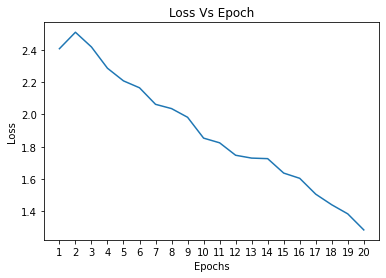

In [40]:
import matplotlib.pyplot as plt
import numpy as np
epochs=[i for i in range(1,21)]
y = losses
x = epochs
plt.xlabel("Epochs") 
plt.ylabel("Loss") 
plt.title("Loss Vs Epoch") 
plt.plot(x, y) 
plt.xticks(x)
plt.show()

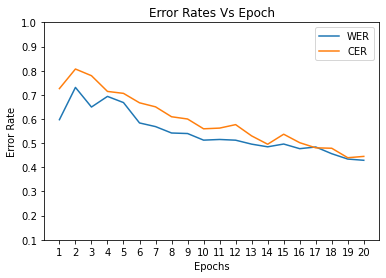

In [42]:
import matplotlib.pyplot as plt
import numpy as np
epochs=[i for i in range(1,21)]
y1 = word_error_rates
y2=character_error_rates
x = epochs
plt.xlabel("Epochs") 
plt.ylabel("Error Rate") 
plt.title("Error Rates Vs Epoch") 
plt.plot(x, y1,label='WER')
plt.plot(x,y2,label='CER') 
plt.ylim(0.1,1.0)
plt.xticks(x)
plt.legend()
plt.show()

# Generating Transcript of single audio file using Trained model

In [43]:
class custom_TestDataset_class(Dataset): 
    _ext_txt = ".trans.txt"
    _ext_audio = ".flac"
    def __init__(self):
        self._path="path to test data folder"
        self._walker=[] # list of audio file names
    def __getitem__(self, n):
        fileid = self._walker[n]
        return load_librispeech_item(fileid, self._path, self._ext_audio, self._ext_txt)

    def __len__(self):
        return len(self._walker)   
    
    
single_audio_dataloader=custom_TestDataset_class()

In [ ]:
def single_audio_test(model, device, test_loader, iter_meter):
    model.eval()
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            output = model(spectrograms)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1)
            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            print(decoded_preds)

single_audio_test(loaded_model, device, single_audio_dataloader, iter)


